In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base = "/Users/claxl/Documents/GitHub/MLProject/Data Exploration/EDA/clearData/"

In [3]:
df_train_est_A = pd.read_csv('train_est_A.csv')
df_train_obs_A = pd.read_csv('train_obs_A.csv')
df_test_A = pd.read_csv('X_test_A.csv')
df_train_est_A = df_train_est_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_obs_A = df_train_obs_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_test_A = df_test_A.rename(columns={'Unnamed: 0': 'date_forecast'})

df_train_est_A.set_index('date_forecast', inplace=True)
df_train_obs_A.set_index('date_forecast', inplace=True)
df_test_A.set_index('date_forecast', inplace=True)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)
df_train_obs_A.index = pd.to_datetime(df_train_obs_A.index)

In [4]:
df_train_obs_A=df_train_obs_A.drop(columns=['snow_density:kgm3'])
df_train_est_A=df_train_est_A.drop(columns=['snow_density:kgm3','date_calc'])


In [5]:
df_train_obs_A = df_train_obs_A.fillna(0)
df_train_est_A = df_train_est_A.fillna(0)
df = pd.concat([df_train_obs_A,df_train_est_A])
df.index = pd.to_datetime(df.index)
df['hours'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df_test_A.index = pd.to_datetime(df_test_A.index)
df_test_A['hours'] = df_test_A.index.hour
df_test_A['day'] = df_test_A.index.day
df_test_A['month'] = df_test_A.index.month
df_test_A['year'] = df_test_A.index.year
df_test_A = df_test_A.drop(columns = 'date_calc', axis = 1)

In [11]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# Sample DataFrame (replace this with your own dataset)
data = df
# Define the number of splits (e.g., 5 for 80-20 train-test splits)
n_splits = 3


# Initialize the TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


In [39]:
def objective(trial):
    param = {
        'objective':'reg:squarederror',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'gamma': trial.suggest_loguniform('gamma',  1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4,1e-0),
        'n_estimators': trial.suggest_int('n_estimators',10,1000),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': 42,
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'eval_metric':'mae'
    }
    model = xgb.XGBRegressor(**param)
    maelist = []
    for train_index, test_index in tscv.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]

        # Extract target variable for training and testing data
        y_train = train_data['pv_measurement']
        y_test = test_data['pv_measurement']

        # Extract features for training and testing data
        X_train = train_data.drop(columns = 'pv_measurement')
        X_test = test_data.drop(columns = 'pv_measurement')
            # Create an XGBoost DMatrix for training and testing data
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        # Train the XGBoost model
        model = xgb.train(param, dtrain)

        # Make predictions on the test data
        y_pred = model.predict(dtest)

        # Evaluate the model using Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, y_pred)
        print("Mean Absolute Error:", mae)
        maelist.append(mae)
    # Return MAE
    mean_mae = np.mean(maelist)

    return mean_mae

In [40]:
import optuna
import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='minimize')

[I 2023-10-25 15:43:57,057] A new study created in memory with name: no-name-ed26b445-3a8e-43c8-b3a3-71e33a0f8cd6


In [41]:
study.optimize(objective, n_trials=200)

Mean Absolute Error: 296.64322904291885
Mean Absolute Error: 273.55231202661344


[I 2023-10-25 15:43:58,484] Trial 0 finished with value: 281.88014318997284 and parameters: {'lambda': 0.46819194612028814, 'alpha': 0.6789809784170098, 'gamma': 0.0016331604794654138, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.815457179674107, 'n_estimators': 918, 'max_depth': 17, 'min_child_weight': 25}. Best is trial 0 with value: 281.88014318997284.


Mean Absolute Error: 275.44488850038624
Mean Absolute Error: 823.676753173507
Mean Absolute Error: 851.3739322919587


[I 2023-10-25 15:43:58,751] Trial 1 finished with value: 832.8709495635622 and parameters: {'lambda': 0.7088385296962716, 'alpha': 0.001965805258845324, 'gamma': 0.42024669561887495, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.0011730600047952695, 'n_estimators': 243, 'max_depth': 11, 'min_child_weight': 131}. Best is trial 0 with value: 281.88014318997284.


Mean Absolute Error: 823.5621632252211
Mean Absolute Error: 242.76958407524097
Mean Absolute Error: 219.29525618655646


[I 2023-10-25 15:43:59,011] Trial 2 finished with value: 224.12921825457113 and parameters: {'lambda': 0.09386369212687656, 'alpha': 0.6489593549017654, 'gamma': 0.0025970098757417143, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.42572902700039517, 'n_estimators': 677, 'max_depth': 15, 'min_child_weight': 201}. Best is trial 2 with value: 224.12921825457113.


Mean Absolute Error: 210.32281450191593
Mean Absolute Error: 693.0461768221984
Mean Absolute Error: 713.6517258457293


[I 2023-10-25 15:43:59,262] Trial 3 finished with value: 698.6749794313251 and parameters: {'lambda': 0.001274386971846746, 'alpha': 0.0019060073269872436, 'gamma': 0.004870609808293579, 'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.02221379116631802, 'n_estimators': 313, 'max_depth': 13, 'min_child_weight': 238}. Best is trial 2 with value: 224.12921825457113.


Mean Absolute Error: 689.3270356260476
Mean Absolute Error: 831.3039948820115
Mean Absolute Error: 859.3189248161922


[I 2023-10-25 15:43:59,503] Trial 4 finished with value: 840.6491744327777 and parameters: {'lambda': 1.7915541039955467, 'alpha': 0.865334334591974, 'gamma': 2.0438178936451203, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.00011303384978251335, 'n_estimators': 839, 'max_depth': 15, 'min_child_weight': 171}. Best is trial 2 with value: 224.12921825457113.


Mean Absolute Error: 831.3246036001296
Mean Absolute Error: 829.8075712165883
Mean Absolute Error: 857.7583730469918


[I 2023-10-25 15:43:59,754] Trial 5 finished with value: 839.1239076612327 and parameters: {'lambda': 0.21103608467907067, 'alpha': 0.001686712467265945, 'gamma': 1.3754868473916047, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.0003213698967474723, 'n_estimators': 10, 'max_depth': 9, 'min_child_weight': 264}. Best is trial 2 with value: 224.12921825457113.


Mean Absolute Error: 829.8057787201179
Mean Absolute Error: 261.5776248911596
Mean Absolute Error: 238.76667055726094


[I 2023-10-25 15:44:00,045] Trial 6 finished with value: 241.99975562475424 and parameters: {'lambda': 1.4778445256326844, 'alpha': 0.24444049062204537, 'gamma': 0.3274639401970028, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.8179245414647088, 'n_estimators': 807, 'max_depth': 13, 'min_child_weight': 161}. Best is trial 2 with value: 224.12921825457113.


Mean Absolute Error: 225.65497142584215
Mean Absolute Error: 828.7482993822814
Mean Absolute Error: 856.68289147063


[I 2023-10-25 15:44:00,278] Trial 7 finished with value: 838.0678734142685 and parameters: {'lambda': 0.6183664158152747, 'alpha': 0.31203307328778207, 'gamma': 0.020587008652890076, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.00046259993648491653, 'n_estimators': 264, 'max_depth': 5, 'min_child_weight': 34}. Best is trial 2 with value: 224.12921825457113.


Mean Absolute Error: 828.7724293898943
Mean Absolute Error: 238.24322662269452
Mean Absolute Error: 218.77439987838133


[I 2023-10-25 15:44:00,524] Trial 8 finished with value: 223.74133658921676 and parameters: {'lambda': 0.2596820938037719, 'alpha': 1.1636272308154987, 'gamma': 0.013755045414179134, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.39475363700647126, 'n_estimators': 71, 'max_depth': 7, 'min_child_weight': 155}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 214.20638326657448
Mean Absolute Error: 278.20338700743787
Mean Absolute Error: 259.90865155422034


[I 2023-10-25 15:44:04,486] Trial 9 finished with value: 265.5341672564429 and parameters: {'lambda': 0.0013298341317625102, 'alpha': 0.10683715542358521, 'gamma': 0.03587366751661083, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.21576036643955868, 'n_estimators': 820, 'max_depth': 13, 'min_child_weight': 4}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 258.49046320767053
Mean Absolute Error: 522.1764235829332
Mean Absolute Error: 533.4618793205678


[I 2023-10-25 15:44:04,790] Trial 10 finished with value: 523.136495845025 and parameters: {'lambda': 9.299420928055024, 'alpha': 7.38185331474955, 'gamma': 5.6697406809708815, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.060438069152189536, 'n_estimators': 10, 'max_depth': 7, 'min_child_weight': 94}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 513.771184631574
Mean Absolute Error: 383.68638302364474
Mean Absolute Error: 375.78884242756436


[I 2023-10-25 15:44:05,040] Trial 11 finished with value: 373.7968043976566 and parameters: {'lambda': 0.05286093178027264, 'alpha': 3.1943615932037144, 'gamma': 0.0010503260391259827, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.12017890614102708, 'n_estimators': 589, 'max_depth': 7, 'min_child_weight': 217}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 361.9151877417608
Mean Absolute Error: 778.5988752385051
Mean Absolute Error: 800.6834218225569


[I 2023-10-25 15:44:05,291] Trial 12 finished with value: 784.430731367368 and parameters: {'lambda': 0.057565872647762806, 'alpha': 1.7869223309336848, 'gamma': 0.0077725831687834816, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.0092022784790255, 'n_estimators': 587, 'max_depth': 15, 'min_child_weight': 300}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 774.0098970410424
Mean Absolute Error: 240.38262115769103
Mean Absolute Error: 221.03448863275398


[I 2023-10-25 15:44:05,562] Trial 13 finished with value: 225.9946852541054 and parameters: {'lambda': 0.029194141619577448, 'alpha': 6.709467495413087, 'gamma': 0.027040660855031536, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.34478034432980803, 'n_estimators': 420, 'max_depth': 7, 'min_child_weight': 199}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 216.56694597187118
Mean Absolute Error: 444.2011201435988
Mean Absolute Error: 448.36640247576287


[I 2023-10-25 15:44:05,846] Trial 14 finished with value: 441.365537562777 and parameters: {'lambda': 0.01699951606215572, 'alpha': 0.028307256121107557, 'gamma': 0.006617210115291365, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.0853005769606995, 'n_estimators': 640, 'max_depth': 15, 'min_child_weight': 108}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 431.52909006896914
Mean Absolute Error: 244.4572789425069
Mean Absolute Error: 224.08990074489412


[I 2023-10-25 15:44:06,134] Trial 15 finished with value: 229.18890176911222 and parameters: {'lambda': 0.1485347849033112, 'alpha': 1.8564504274210079, 'gamma': 0.1146971736889191, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.33261866032775755, 'n_estimators': 156, 'max_depth': 11, 'min_child_weight': 79}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 219.01952561993562
Mean Absolute Error: 269.5256479859985
Mean Absolute Error: 241.2579518277459


[I 2023-10-25 15:44:06,448] Trial 16 finished with value: 248.58894324342054 and parameters: {'lambda': 0.011840560279383202, 'alpha': 0.6428133108541936, 'gamma': 0.002758010851080267, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.9836912725223929, 'n_estimators': 430, 'max_depth': 17, 'min_child_weight': 189}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 234.98322991651722
Mean Absolute Error: 681.7704486103695
Mean Absolute Error: 703.3452870032041


[I 2023-10-25 15:44:06,741] Trial 17 finished with value: 688.3602481314771 and parameters: {'lambda': 0.15205142519872292, 'alpha': 0.054045676309666245, 'gamma': 0.01077100930946821, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.023539136462379623, 'n_estimators': 700, 'max_depth': 9, 'min_child_weight': 145}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 679.9650087808575
Mean Absolute Error: 283.93680480982584
Mean Absolute Error: 274.8172721638136


[I 2023-10-25 15:44:06,993] Trial 18 finished with value: 274.7527537322549 and parameters: {'lambda': 0.06938485296492476, 'alpha': 3.644404035960266, 'gamma': 0.0025566085270526924, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.19888688508284288, 'n_estimators': 975, 'max_depth': 5, 'min_child_weight': 247}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 265.5041842231253
Mean Absolute Error: 572.1112791491234
Mean Absolute Error: 581.7733557004807


[I 2023-10-25 15:44:07,279] Trial 19 finished with value: 572.0860692004012 and parameters: {'lambda': 0.007572988483801738, 'alpha': 0.21879683631764074, 'gamma': 0.046254487214669834, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.0506123034559809, 'n_estimators': 472, 'max_depth': 7, 'min_child_weight': 64}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 562.3735727515995
Mean Absolute Error: 790.327053736867


[I 2023-10-25 15:44:07,600] Trial 20 finished with value: 798.5294548768985 and parameters: {'lambda': 0.2503869909372108, 'alpha': 9.988717387234852, 'gamma': 0.0034760979230145004, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.005978615383087057, 'n_estimators': 730, 'max_depth': 15, 'min_child_weight': 120}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 816.1041125118902
Mean Absolute Error: 789.1571983819383


[I 2023-10-25 15:44:07,862] Trial 21 finished with value: 225.65856405248056 and parameters: {'lambda': 0.034946578626112834, 'alpha': 4.158748531380005, 'gamma': 0.013002068878634771, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3449276023639588, 'n_estimators': 369, 'max_depth': 7, 'min_child_weight': 197}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 240.94422141731079
Mean Absolute Error: 218.74234426165125
Mean Absolute Error: 217.2891264784797


[I 2023-10-25 15:44:08,122] Trial 22 finished with value: 226.69515773520843 and parameters: {'lambda': 0.08882338133038224, 'alpha': 1.5828656343201994, 'gamma': 0.01234532733449716, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4679768392809909, 'n_estimators': 133, 'max_depth': 7, 'min_child_weight': 210}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 241.76038270493586
Mean Absolute Error: 221.12753965898727
Mean Absolute Error: 217.19755084170208


[I 2023-10-25 15:44:08,384] Trial 23 finished with value: 336.19364132418264 and parameters: {'lambda': 0.03358079171504369, 'alpha': 4.380350129896964, 'gamma': 0.0010845219482909804, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.1389842232605177, 'n_estimators': 353, 'max_depth': 7, 'min_child_weight': 176}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 341.33887589105046
Mean Absolute Error: 340.2525256646956
Mean Absolute Error: 326.98952241680183


[I 2023-10-25 15:44:08,668] Trial 24 finished with value: 224.68392037282402 and parameters: {'lambda': 0.1172079116847808, 'alpha': 1.3194816857612524, 'gamma': 0.013825473273350064, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.37920735811662726, 'n_estimators': 541, 'max_depth': 7, 'min_child_weight': 149}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 241.52269511515865
Mean Absolute Error: 217.96295573906727
Mean Absolute Error: 214.56611026424622


[I 2023-10-25 15:44:08,946] Trial 25 finished with value: 301.3000821246606 and parameters: {'lambda': 0.30291700747225164, 'alpha': 1.0137245605318816, 'gamma': 0.005451089991102853, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.16583713784287538, 'n_estimators': 551, 'max_depth': 15, 'min_child_weight': 146}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 309.9334430886843
Mean Absolute Error: 301.3495855224157
Mean Absolute Error: 292.61721776288175


[I 2023-10-25 15:44:09,197] Trial 26 finished with value: 240.3869136440676 and parameters: {'lambda': 0.1208690488381653, 'alpha': 0.4868947339170013, 'gamma': 0.0027452305168688385, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.4503912363273521, 'n_estimators': 679, 'max_depth': 7, 'min_child_weight': 232}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 263.5473771216467
Mean Absolute Error: 235.05330517806303
Mean Absolute Error: 222.56005863249294


[I 2023-10-25 15:44:09,459] Trial 27 finished with value: 449.58765164565756 and parameters: {'lambda': 0.1057848194029312, 'alpha': 1.4037029527188631, 'gamma': 0.017562251043490944, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.08367187184426456, 'n_estimators': 525, 'max_depth': 17, 'min_child_weight': 276}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 451.28165244119026
Mean Absolute Error: 457.60092020283673
Mean Absolute Error: 439.8803822929456


[I 2023-10-25 15:44:09,693] Trial 28 finished with value: 244.76039987588914 and parameters: {'lambda': 0.33980205438185923, 'alpha': 0.48772055427551275, 'gamma': 0.05845451222074101, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.5967216253919067, 'n_estimators': 767, 'max_depth': 5, 'min_child_weight': 140}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 266.90448775354065
Mean Absolute Error: 234.6483551020851
Mean Absolute Error: 232.7283567720417


[I 2023-10-25 15:44:09,971] Trial 29 finished with value: 255.88076764707913 and parameters: {'lambda': 0.4902331330785893, 'alpha': 0.7665312099878075, 'gamma': 0.0017587554768439663, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.9608627575161693, 'n_estimators': 612, 'max_depth': 9, 'min_child_weight': 178}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 285.8498751288096
Mean Absolute Error: 245.16716404349964
Mean Absolute Error: 236.62526376892828


[I 2023-10-25 15:44:10,256] Trial 30 finished with value: 236.94398253683542 and parameters: {'lambda': 0.1647242791106682, 'alpha': 2.3234927134432466, 'gamma': 0.008070932209900267, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.26840276336654045, 'n_estimators': 899, 'max_depth': 11, 'min_child_weight': 115}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 247.02000031685117
Mean Absolute Error: 234.13723896798126
Mean Absolute Error: 229.67470832567383


[I 2023-10-25 15:44:10,524] Trial 31 finished with value: 228.5024113572973 and parameters: {'lambda': 0.0379541481960729, 'alpha': 3.9671821007487504, 'gamma': 0.014463680817007914, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5160405885370706, 'n_estimators': 125, 'max_depth': 7, 'min_child_weight': 199}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 247.45758645845905
Mean Absolute Error: 220.07659409717485
Mean Absolute Error: 217.973053516258


[I 2023-10-25 15:44:10,804] Trial 32 finished with value: 232.16618664237862 and parameters: {'lambda': 0.07688463555915656, 'alpha': 1.489562483587747, 'gamma': 0.021368685944005948, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.28789640146428547, 'n_estimators': 477, 'max_depth': 7, 'min_child_weight': 159}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 244.78529611684937
Mean Absolute Error: 227.585066618685
Mean Absolute Error: 224.12819719160137


[I 2023-10-25 15:44:11,077] Trial 33 finished with value: 225.84916253227433 and parameters: {'lambda': 0.24994066373037166, 'alpha': 2.4944631004405213, 'gamma': 0.00442434061630868, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.5730123594164996, 'n_estimators': 228, 'max_depth': 7, 'min_child_weight': 217}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 243.88848095582188
Mean Absolute Error: 222.51760429547772
Mean Absolute Error: 211.14140234552337
Mean Absolute Error: 315.17504179784004
Mean Absolute Error: 311.1734562502978
Mean Absolute Error: 302.0565598683197


[I 2023-10-25 15:44:11,381] Trial 34 finished with value: 309.46835263881917 and parameters: {'lambda': 0.10712258228571002, 'alpha': 4.354520326278616, 'gamma': 0.010761359903950005, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.15090829655235463, 'n_estimators': 358, 'max_depth': 7, 'min_child_weight': 127}. Best is trial 8 with value: 223.74133658921676.
[I 2023-10-25 15:44:11,666] Trial 35 finished with value: 259.55323168357756 and parameters: {'lambda': 0.8668317281635981, 'alpha': 1.0459668738574976, 'gamma': 0.0050845875111439325, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.23565374161795122, 'n_estimators': 396, 'max_depth': 15, 'min_child_weight': 187}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 269.77667227912616
Mean Absolute Error: 258.30864023060565
Mean Absolute Error: 250.57438254100086
Mean Absolute Error: 282.7088811007882
Mean Absolute Error: 247.56787278295891


[I 2023-10-25 15:44:11,995] Trial 36 finished with value: 255.31988968168142 and parameters: {'lambda': 0.38931095012977124, 'alpha': 0.9886288480383347, 'gamma': 0.08674654949472356, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.9295329834086207, 'n_estimators': 64, 'max_depth': 17, 'min_child_weight': 163}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 235.68291516129716
Mean Absolute Error: 253.1733773030403
Mean Absolute Error: 223.66365817871295


[I 2023-10-25 15:44:12,285] Trial 37 finished with value: 229.64829847774857 and parameters: {'lambda': 0.17409927939332825, 'alpha': 0.41350543014975943, 'gamma': 0.033239358968174, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.44319888352431874, 'n_estimators': 299, 'max_depth': 13, 'min_child_weight': 236}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 212.10785995149254
Mean Absolute Error: 620.2154306900796
Mean Absolute Error: 636.7620461699969


[I 2023-10-25 15:44:12,572] Trial 38 finished with value: 623.7773152543224 and parameters: {'lambda': 0.02359497371537986, 'alpha': 2.4889558033548447, 'gamma': 0.0017385078236746467, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.035934901420431785, 'n_estimators': 195, 'max_depth': 7, 'min_child_weight': 134}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 614.3544689028909
Mean Absolute Error: 381.0334586520652
Mean Absolute Error: 384.8446418447395


[I 2023-10-25 15:44:12,889] Trial 39 finished with value: 378.2255749047196 and parameters: {'lambda': 0.04103936079586656, 'alpha': 5.977739639121542, 'gamma': 0.01642806766398173, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.10963955296872348, 'n_estimators': 651, 'max_depth': 11, 'min_child_weight': 168}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 368.79862421735425
Mean Absolute Error: 265.07179660057176
Mean Absolute Error: 240.72449359705536


[I 2023-10-25 15:44:13,181] Trial 40 finished with value: 247.01133118807763 and parameters: {'lambda': 0.8517368403356437, 'alpha': 9.775971231998023, 'gamma': 0.007993174079817613, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.6610045752784887, 'n_estimators': 65, 'max_depth': 15, 'min_child_weight': 201}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 235.2377033666058
Mean Absolute Error: 267.49894151845257
Mean Absolute Error: 223.8386087272253


[I 2023-10-25 15:44:13,458] Trial 41 finished with value: 237.16717911793296 and parameters: {'lambda': 0.24578722024000246, 'alpha': 3.0010554706347357, 'gamma': 0.004092537080418013, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.6058866309312763, 'n_estimators': 266, 'max_depth': 7, 'min_child_weight': 218}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 220.16398710812098
Mean Absolute Error: 247.52441934166166
Mean Absolute Error: 225.4936890604667


[I 2023-10-25 15:44:13,738] Trial 42 finished with value: 230.194057943688 and parameters: {'lambda': 0.05905603504504631, 'alpha': 2.792817727602424, 'gamma': 0.004572285534017742, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3162587033688607, 'n_estimators': 222, 'max_depth': 7, 'min_child_weight': 257}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 217.56406542893558
Mean Absolute Error: 260.59236773889324
Mean Absolute Error: 249.62634458432603


[I 2023-10-25 15:44:14,018] Trial 43 finished with value: 249.73713719394482 and parameters: {'lambda': 0.23250947891609075, 'alpha': 1.1689339786749176, 'gamma': 0.025708766501382572, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.2344111159625903, 'n_estimators': 328, 'max_depth': 7, 'min_child_weight': 188}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 238.99269925861518
Mean Absolute Error: 261.20891398849284
Mean Absolute Error: 228.14065059632608


[I 2023-10-25 15:44:14,320] Trial 44 finished with value: 235.7631789816287 and parameters: {'lambda': 0.5340562228335082, 'alpha': 2.0553019676266686, 'gamma': 0.0076647627267520365, 'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.6663178620469221, 'n_estimators': 63, 'max_depth': 13, 'min_child_weight': 221}. Best is trial 8 with value: 223.74133658921676.


Mean Absolute Error: 217.93997236006712
Mean Absolute Error: 240.24509673089563
Mean Absolute Error: 211.74939339101203


[I 2023-10-25 15:44:14,600] Trial 45 finished with value: 221.22919578949885 and parameters: {'lambda': 0.09089121155767084, 'alpha': 0.6943253517520387, 'gamma': 0.0033758049038647934, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4385727517291623, 'n_estimators': 218, 'max_depth': 7, 'min_child_weight': 151}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 211.6930972465889
Mean Absolute Error: 300.3336590614497
Mean Absolute Error: 292.92289055513913


[I 2023-10-25 15:44:14,877] Trial 46 finished with value: 291.7039731950033 and parameters: {'lambda': 0.08406177714489524, 'alpha': 0.7154482287722629, 'gamma': 0.011222115225391915, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.17550651919920673, 'n_estimators': 183, 'max_depth': 7, 'min_child_weight': 165}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 281.8553699684211
Mean Absolute Error: 240.748486508138
Mean Absolute Error: 212.39641909343007


[I 2023-10-25 15:44:15,166] Trial 47 finished with value: 223.18833629655606 and parameters: {'lambda': 0.06067624595819483, 'alpha': 0.29806804805411563, 'gamma': 0.0020211489652640783, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.3630048576888468, 'n_estimators': 288, 'max_depth': 9, 'min_child_weight': 103}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 216.42010328810005
Mean Absolute Error: 409.53093181535746
Mean Absolute Error: 409.641119679539


[I 2023-10-25 15:44:15,458] Trial 48 finished with value: 405.11864442545874 and parameters: {'lambda': 0.05231475570377665, 'alpha': 0.25228563674589927, 'gamma': 0.0020446223280473014, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.09961945240133341, 'n_estimators': 115, 'max_depth': 9, 'min_child_weight': 101}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 396.1838817814796
Mean Absolute Error: 268.1030861056095
Mean Absolute Error: 255.21211678574178


[I 2023-10-25 15:44:15,742] Trial 49 finished with value: 257.49659327207075 and parameters: {'lambda': 0.1351470943916803, 'alpha': 0.17918653032373877, 'gamma': 0.0012689014209046792, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.2201469108114545, 'n_estimators': 281, 'max_depth': 9, 'min_child_weight': 82}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 249.17457692486093
Mean Absolute Error: 238.18727517869962


[I 2023-10-25 15:44:16,067] Trial 50 finished with value: 222.55020824612816 and parameters: {'lambda': 0.18471044113564766, 'alpha': 0.34666097504299204, 'gamma': 0.002828338226742927, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.410505834820868, 'n_estimators': 531, 'max_depth': 9, 'min_child_weight': 33}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 218.09554657376623
Mean Absolute Error: 211.36780298591873


[I 2023-10-25 15:44:16,377] Trial 51 finished with value: 226.1162727095572 and parameters: {'lambda': 0.1776206999124953, 'alpha': 0.3579629611683387, 'gamma': 0.002834247493992591, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.4178977571199462, 'n_estimators': 457, 'max_depth': 9, 'min_child_weight': 44}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 248.74162660137603
Mean Absolute Error: 221.12023326643887
Mean Absolute Error: 208.4869582608567


[I 2023-10-25 15:44:16,687] Trial 52 finished with value: 268.7213347812434 and parameters: {'lambda': 0.09574760192328059, 'alpha': 0.6144979581800043, 'gamma': 0.001441070197941949, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.7728311480565424, 'n_estimators': 562, 'max_depth': 9, 'min_child_weight': 29}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 294.51201008817907
Mean Absolute Error: 259.23956257166327
Mean Absolute Error: 252.4124316838878
Mean Absolute Error: 272.9045785817312
Mean Absolute Error: 239.6970134082124


[I 2023-10-25 15:44:17,206] Trial 53 finished with value: 248.23425928025586 and parameters: {'lambda': 0.38462345668427633, 'alpha': 0.3252350929907156, 'gamma': 0.002373207846791066, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.35034737468831023, 'n_estimators': 519, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 232.10118585082392
Mean Absolute Error: 329.3437994849775
Mean Absolute Error: 327.2247256582512


[I 2023-10-25 15:44:17,531] Trial 54 finished with value: 324.30377625149254 and parameters: {'lambda': 0.0652854249831086, 'alpha': 0.15732075555706687, 'gamma': 0.0034127147957436965, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.1391244659819941, 'n_estimators': 754, 'max_depth': 9, 'min_child_weight': 48}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 316.34280361124894
Mean Absolute Error: 268.54780536895703


[I 2023-10-25 15:44:19,119] Trial 55 finished with value: 260.96896234764256 and parameters: {'lambda': 0.1275506450902823, 'alpha': 0.5681924371098376, 'gamma': 0.001970581186747152, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.21435795228742727, 'n_estimators': 599, 'max_depth': 5, 'min_child_weight': 91}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 259.9402140789126
Mean Absolute Error: 254.41886759505803
Mean Absolute Error: 246.30561312155922
Mean Absolute Error: 230.08381589947584


[I 2023-10-25 15:44:19,820] Trial 56 finished with value: 233.15080002506912 and parameters: {'lambda': 0.2285488210316099, 'alpha': 0.8805992576157473, 'gamma': 0.0010932033126947968, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.40020054786671416, 'n_estimators': 15, 'max_depth': 15, 'min_child_weight': 13}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 223.06297105417227
Mean Absolute Error: 275.3075416566629
Mean Absolute Error: 244.94639756866542


[I 2023-10-25 15:44:20,116] Trial 57 finished with value: 252.4703263638348 and parameters: {'lambda': 0.07129735455098567, 'alpha': 0.28719777887211034, 'gamma': 0.0035368369102352416, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.9954353352012799, 'n_estimators': 432, 'max_depth': 9, 'min_child_weight': 155}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 237.15703986617598
Mean Absolute Error: 503.2754528220215
Mean Absolute Error: 505.6012784943149


[I 2023-10-25 15:44:20,411] Trial 58 finished with value: 498.52414072009446 and parameters: {'lambda': 0.16396649948040312, 'alpha': 0.3949858878030809, 'gamma': 0.006266208164202662, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.07189639720518017, 'n_estimators': 844, 'max_depth': 17, 'min_child_weight': 68}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 486.695690843947
Mean Absolute Error: 240.68245320229454
Mean Absolute Error: 225.92572507805352


[I 2023-10-25 15:44:20,716] Trial 59 finished with value: 228.12034319869224 and parameters: {'lambda': 0.05361809419819074, 'alpha': 0.7004599079930963, 'gamma': 0.0015478482724803411, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.31200248061137253, 'n_estimators': 634, 'max_depth': 15, 'min_child_weight': 128}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 217.75285131572863
Mean Absolute Error: 290.6050451575477


[I 2023-10-25 15:44:21,056] Trial 60 finished with value: 282.5897215477282 and parameters: {'lambda': 0.11199675744038871, 'alpha': 1.463655159781223, 'gamma': 0.002381693464817573, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.17360693641413244, 'n_estimators': 493, 'max_depth': 11, 'min_child_weight': 115}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 283.29743210056046
Mean Absolute Error: 273.8666873850764


[I 2023-10-25 15:44:21,338] Trial 61 finished with value: 221.444368853381 and parameters: {'lambda': 0.0260180616114046, 'alpha': 0.5052190815575737, 'gamma': 0.005491925566199464, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4309854093633406, 'n_estimators': 383, 'max_depth': 7, 'min_child_weight': 150}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 240.44488107732607
Mean Absolute Error: 213.18659981782633
Mean Absolute Error: 210.70162566499064


[I 2023-10-25 15:44:21,624] Trial 62 finished with value: 224.77135919411367 and parameters: {'lambda': 0.019771058602663216, 'alpha': 0.5023307998528106, 'gamma': 0.005990448967458742, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5111114513330043, 'n_estimators': 246, 'max_depth': 7, 'min_child_weight': 150}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 242.92165487329808
Mean Absolute Error: 217.19411029761167
Mean Absolute Error: 214.19831241143132


[I 2023-10-25 15:44:21,900] Trial 63 finished with value: 233.821666604156 and parameters: {'lambda': 0.041619488883051094, 'alpha': 0.8445239409179004, 'gamma': 0.0036941835119921776, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.6454686093645241, 'n_estimators': 376, 'max_depth': 7, 'min_child_weight': 137}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 249.49106965390536
Mean Absolute Error: 235.02894987834097
Mean Absolute Error: 216.94498028022164


[I 2023-10-25 15:44:22,204] Trial 64 finished with value: 224.42805708471568 and parameters: {'lambda': 0.027418547180670848, 'alpha': 0.493938597824286, 'gamma': 0.004947808043504649, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.3096832801182969, 'n_estimators': 322, 'max_depth': 13, 'min_child_weight': 179}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 237.5654921946864
Mean Absolute Error: 219.7565612661843
Mean Absolute Error: 215.9621177932763


[I 2023-10-25 15:44:22,481] Trial 65 finished with value: 373.50177821575727 and parameters: {'lambda': 0.02082230972888046, 'alpha': 0.22804320503682327, 'gamma': 0.003104551627154159, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.11574666461120661, 'n_estimators': 328, 'max_depth': 13, 'min_child_weight': 180}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 378.1490774375899
Mean Absolute Error: 378.49277262209193
Mean Absolute Error: 363.8634845875901


[I 2023-10-25 15:44:22,767] Trial 66 finished with value: 238.88138567440834 and parameters: {'lambda': 0.01589658798212674, 'alpha': 0.4157776638926412, 'gamma': 0.005531054243835764, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.26055744768457156, 'n_estimators': 412, 'max_depth': 13, 'min_child_weight': 206}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 251.55343083345494
Mean Absolute Error: 236.66737590115915
Mean Absolute Error: 228.423350288611


[I 2023-10-25 15:44:23,053] Trial 67 finished with value: 226.7773386267555 and parameters: {'lambda': 0.02704852670840929, 'alpha': 0.13611637271752292, 'gamma': 0.0021670297859404312, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.465130497531646, 'n_estimators': 311, 'max_depth': 13, 'min_child_weight': 172}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 239.3130329177371
Mean Absolute Error: 224.27201981152223
Mean Absolute Error: 216.74696315100715


[I 2023-10-25 15:44:23,315] Trial 68 finished with value: 249.49546308487052 and parameters: {'lambda': 0.0324080962846315, 'alpha': 0.2901330671606903, 'gamma': 0.001007601175140579, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.8004424773505165, 'n_estimators': 172, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 276.9821489395247
Mean Absolute Error: 241.9484759248465
Mean Absolute Error: 229.55576439024045


[I 2023-10-25 15:44:23,605] Trial 69 finished with value: 228.77547296963112 and parameters: {'lambda': 0.010974605333166462, 'alpha': 0.5531417078238011, 'gamma': 0.004683127735812396, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.3100864839572626, 'n_estimators': 225, 'max_depth': 9, 'min_child_weight': 57}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 242.05719463459943
Mean Absolute Error: 222.81351395486433
Mean Absolute Error: 221.45571031942964


[I 2023-10-25 15:44:23,887] Trial 70 finished with value: 298.46908219598623 and parameters: {'lambda': 0.0851558059338333, 'alpha': 0.10432105911018333, 'gamma': 0.008772321324340906, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.16710812079637838, 'n_estimators': 101, 'max_depth': 13, 'min_child_weight': 192}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 306.68941373484023
Mean Absolute Error: 301.2086670242709
Mean Absolute Error: 287.50916582884764


[I 2023-10-25 15:44:24,168] Trial 71 finished with value: 221.78356978274397 and parameters: {'lambda': 0.04801175974789706, 'alpha': 1.1563787409959803, 'gamma': 0.009762272024248756, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.36719161318364685, 'n_estimators': 571, 'max_depth': 7, 'min_child_weight': 146}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 235.7731049773676
Mean Absolute Error: 217.67567907605985
Mean Absolute Error: 211.90192529480444


[I 2023-10-25 15:44:24,452] Trial 72 finished with value: 222.86987736932485 and parameters: {'lambda': 0.04984868986751206, 'alpha': 1.1606462734359457, 'gamma': 0.002831350703686748, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.399587261076225, 'n_estimators': 702, 'max_depth': 7, 'min_child_weight': 141}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 246.32781479593814
Mean Absolute Error: 213.51740423843202
Mean Absolute Error: 208.7644130736044


[I 2023-10-25 15:44:24,737] Trial 73 finished with value: 221.30335759963089 and parameters: {'lambda': 0.05133285654833836, 'alpha': 1.9119290609288777, 'gamma': 0.0015087204764433026, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.48667504954456686, 'n_estimators': 685, 'max_depth': 7, 'min_child_weight': 121}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 241.16712031138255
Mean Absolute Error: 213.99843437515798
Mean Absolute Error: 208.74451811235213


[I 2023-10-25 15:44:25,019] Trial 74 finished with value: 240.67632589947982 and parameters: {'lambda': 0.04719514722017935, 'alpha': 1.7977947952604096, 'gamma': 0.0013653954311451013, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.7581694006124788, 'n_estimators': 723, 'max_depth': 7, 'min_child_weight': 105}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 263.9197352593984
Mean Absolute Error: 233.6396272671609
Mean Absolute Error: 224.46961517188012


[I 2023-10-25 15:44:25,312] Trial 75 finished with value: 223.81061855526823 and parameters: {'lambda': 0.061962658700718584, 'alpha': 1.2918121030606373, 'gamma': 0.002778552910596179, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4322224805912751, 'n_estimators': 568, 'max_depth': 7, 'min_child_weight': 143}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 242.52005153380375
Mean Absolute Error: 215.39098205961236
Mean Absolute Error: 213.52082207238868


[I 2023-10-25 15:44:25,596] Trial 76 finished with value: 222.19789213204078 and parameters: {'lambda': 0.04287833640026367, 'alpha': 0.9185288970140723, 'gamma': 0.001627565699926868, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4989914332182195, 'n_estimators': 678, 'max_depth': 7, 'min_child_weight': 121}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 239.42827528872226
Mean Absolute Error: 215.7907985697707
Mean Absolute Error: 211.37460253762936


[I 2023-10-25 15:44:25,881] Trial 77 finished with value: 224.15206187098715 and parameters: {'lambda': 0.04190861460204057, 'alpha': 0.9183426773735676, 'gamma': 0.0017999516064865486, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5338364908188201, 'n_estimators': 683, 'max_depth': 7, 'min_child_weight': 115}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 241.6416954158662
Mean Absolute Error: 217.3515945412602
Mean Absolute Error: 213.46289565583507


[I 2023-10-25 15:44:26,173] Trial 78 finished with value: 239.89148409056224 and parameters: {'lambda': 0.031361720855352215, 'alpha': 0.7490871044378069, 'gamma': 0.0014550254817699922, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.24843549808536383, 'n_estimators': 784, 'max_depth': 7, 'min_child_weight': 124}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 249.5105248862017
Mean Absolute Error: 239.34237712976451
Mean Absolute Error: 230.82155025572058


[I 2023-10-25 15:44:26,463] Trial 79 finished with value: 235.27817570829123 and parameters: {'lambda': 0.04884427094256562, 'alpha': 1.7355767702688685, 'gamma': 0.0020181016014303985, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.6833835841964327, 'n_estimators': 649, 'max_depth': 7, 'min_child_weight': 97}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 251.10959419482109
Mean Absolute Error: 231.72341043266636
Mean Absolute Error: 223.00152249738628


[I 2023-10-25 15:44:26,739] Trial 80 finished with value: 284.76820049979233 and parameters: {'lambda': 0.0732363246934141, 'alpha': 1.171457758391378, 'gamma': 0.0035869575581078113, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.20345673078686136, 'n_estimators': 705, 'max_depth': 7, 'min_child_weight': 134}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 298.75480394958123
Mean Absolute Error: 283.3063236066939
Mean Absolute Error: 272.24347394310195


[I 2023-10-25 15:44:27,027] Trial 81 finished with value: 225.93217237656017 and parameters: {'lambda': 0.08815934291380945, 'alpha': 1.0872179429940059, 'gamma': 0.0026595972928324663, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5296198030477237, 'n_estimators': 623, 'max_depth': 7, 'min_child_weight': 156}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 238.9759952340362
Mean Absolute Error: 222.54329166085782
Mean Absolute Error: 216.2772302347866


[I 2023-10-25 15:44:27,316] Trial 82 finished with value: 222.71281934606077 and parameters: {'lambda': 0.03756876967526912, 'alpha': 0.6666778194622376, 'gamma': 0.00669102572789183, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.39585052824293226, 'n_estimators': 579, 'max_depth': 7, 'min_child_weight': 142}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 239.67856109685184
Mean Absolute Error: 216.42529804752027
Mean Absolute Error: 212.03459889381017


[I 2023-10-25 15:44:27,593] Trial 83 finished with value: 245.25576066462722 and parameters: {'lambda': 0.036203562537784784, 'alpha': 0.6279990183723009, 'gamma': 0.0036741764241271916, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.8231155904445271, 'n_estimators': 581, 'max_depth': 7, 'min_child_weight': 120}. Best is trial 45 with value: 221.22919578949885.


Mean Absolute Error: 270.67448374888806
Mean Absolute Error: 236.68576288928185
Mean Absolute Error: 228.40703535571174


[I 2023-10-25 15:44:27,877] Trial 84 finished with value: 219.56637612216434 and parameters: {'lambda': 0.053336990005771856, 'alpha': 2.038205297450287, 'gamma': 0.002377871174062422, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.37442399810959087, 'n_estimators': 528, 'max_depth': 7, 'min_child_weight': 108}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 234.47759772342582
Mean Absolute Error: 214.61736669052448
Mean Absolute Error: 209.60416395254273


[I 2023-10-25 15:44:28,169] Trial 85 finished with value: 222.71313037839658 and parameters: {'lambda': 0.046943020162993905, 'alpha': 2.058634933937631, 'gamma': 0.0066187864988996375, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.38889001278644014, 'n_estimators': 535, 'max_depth': 7, 'min_child_weight': 142}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 241.93180900371155
Mean Absolute Error: 216.95786123283514
Mean Absolute Error: 209.24972089864298
Mean Absolute Error: 236.82348834795724
Mean Absolute Error: 227.68094535109503


[I 2023-10-25 15:44:28,502] Trial 86 finished with value: 228.12355359829087 and parameters: {'lambda': 0.02675279726010145, 'alpha': 1.8033322433002028, 'gamma': 0.009778467330508547, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.2742044912057573, 'n_estimators': 534, 'max_depth': 7, 'min_child_weight': 90}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 219.86622709582034
Mean Absolute Error: 243.69949775260565
Mean Absolute Error: 229.119019325203


[I 2023-10-25 15:44:28,788] Trial 87 finished with value: 229.24687984530863 and parameters: {'lambda': 0.04093915069218248, 'alpha': 2.0953576775917053, 'gamma': 0.00689280368011808, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5596513539652004, 'n_estimators': 453, 'max_depth': 7, 'min_child_weight': 149}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 214.92212245811717
Mean Absolute Error: 238.61467317205114
Mean Absolute Error: 213.04152706272527


[I 2023-10-25 15:44:29,090] Trial 88 finished with value: 220.2165821944872 and parameters: {'lambda': 0.03223605674683457, 'alpha': 2.3567897905807933, 'gamma': 0.006819675786827159, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3706764128795545, 'n_estimators': 505, 'max_depth': 7, 'min_child_weight': 112}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 208.9935463486852
Mean Absolute Error: 268.1175554196079
Mean Absolute Error: 256.56708907349235


[I 2023-10-25 15:44:29,386] Trial 89 finished with value: 257.8223523737434 and parameters: {'lambda': 0.021541741201875013, 'alpha': 3.3705893300524714, 'gamma': 0.004271687691533801, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.21080968475055492, 'n_estimators': 661, 'max_depth': 7, 'min_child_weight': 112}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 248.78241262813003
Mean Absolute Error: 344.59789375402806
Mean Absolute Error: 342.56333199312945


[I 2023-10-25 15:44:29,673] Trial 90 finished with value: 339.58399153734155 and parameters: {'lambda': 0.09861466582330149, 'alpha': 1.4640822442196384, 'gamma': 0.0016377508175794801, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.1363637433764601, 'n_estimators': 486, 'max_depth': 7, 'min_child_weight': 80}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 331.59074886486724
Mean Absolute Error: 241.9144283389806
Mean Absolute Error: 217.44412535014416


[I 2023-10-25 15:44:29,984] Trial 91 finished with value: 223.17476976283788 and parameters: {'lambda': 0.07202966188474733, 'alpha': 2.401222451957364, 'gamma': 0.006807839208554115, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.35950750777976964, 'n_estimators': 516, 'max_depth': 7, 'min_child_weight': 128}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 210.1657555993889
Mean Absolute Error: 239.90890589874226
Mean Absolute Error: 216.7228523979408


[I 2023-10-25 15:44:30,274] Trial 92 finished with value: 222.918593932351 and parameters: {'lambda': 0.03252729233860698, 'alpha': 2.8157826413438825, 'gamma': 0.010304151262463927, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5041072048089618, 'n_estimators': 542, 'max_depth': 7, 'min_child_weight': 138}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 212.12402350036996
Mean Absolute Error: 259.1307559163609
Mean Absolute Error: 224.77301737263906


[I 2023-10-25 15:44:30,560] Trial 93 finished with value: 234.20464266279205 and parameters: {'lambda': 0.0614355678730152, 'alpha': 0.8871202098346763, 'gamma': 0.00564246182410294, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.6725106578011258, 'n_estimators': 591, 'max_depth': 7, 'min_child_weight': 121}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 218.71015469937618
Mean Absolute Error: 242.95426365915208
Mean Absolute Error: 228.02762024397543


[I 2023-10-25 15:44:30,869] Trial 94 finished with value: 231.5102385125314 and parameters: {'lambda': 0.03805317198944464, 'alpha': 2.2275643053181144, 'gamma': 0.008746660719207076, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.2774495705267767, 'n_estimators': 506, 'max_depth': 7, 'min_child_weight': 165}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 223.54883163446675
Mean Absolute Error: 241.9550793804368


[I 2023-10-25 15:44:31,202] Trial 95 finished with value: 223.6144532993582 and parameters: {'lambda': 0.025314328716761626, 'alpha': 1.5958421794714546, 'gamma': 0.004317036366205187, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.397054851188501, 'n_estimators': 603, 'max_depth': 17, 'min_child_weight': 160}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 216.37137440785875
Mean Absolute Error: 212.516906109779


[I 2023-10-25 15:44:31,512] Trial 96 finished with value: 250.2900944509876 and parameters: {'lambda': 0.04983320370289783, 'alpha': 0.7413607124906925, 'gamma': 0.012772746686482345, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.9054439511753775, 'n_estimators': 560, 'max_depth': 11, 'min_child_weight': 134}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 277.58406817948185
Mean Absolute Error: 242.96858071196493
Mean Absolute Error: 230.31763446151604


[I 2023-10-25 15:44:31,780] Trial 97 finished with value: 238.99765249406104 and parameters: {'lambda': 0.13252453019461274, 'alpha': 1.2766852108904165, 'gamma': 0.003241481599615065, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.5969676033801629, 'n_estimators': 467, 'max_depth': 7, 'min_child_weight': 145}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 263.0091603937889
Mean Absolute Error: 230.85251047646312
Mean Absolute Error: 223.13128661193113


[I 2023-10-25 15:44:32,068] Trial 98 finished with value: 222.6391721672294 and parameters: {'lambda': 0.017516781787242783, 'alpha': 3.655018080256793, 'gamma': 0.0023227890276705096, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.3325227340001589, 'n_estimators': 616, 'max_depth': 7, 'min_child_weight': 131}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 234.37341065682602
Mean Absolute Error: 221.0587207686064
Mean Absolute Error: 212.4853850762557


[I 2023-10-25 15:44:32,398] Trial 99 finished with value: 274.32658269796957 and parameters: {'lambda': 0.03210860537238923, 'alpha': 5.078467521332576, 'gamma': 0.002199707783489526, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.1846158555170446, 'n_estimators': 626, 'max_depth': 7, 'min_child_weight': 130}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 281.34322198206013
Mean Absolute Error: 275.51847924849216
Mean Absolute Error: 266.1180468633565


[I 2023-10-25 15:44:32,672] Trial 100 finished with value: 241.76190584938664 and parameters: {'lambda': 0.02132469837015394, 'alpha': 3.2832375037790174, 'gamma': 0.002399503466110272, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.24981412879622383, 'n_estimators': 572, 'max_depth': 5, 'min_child_weight': 113}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 250.1621516435977
Mean Absolute Error: 241.3052661862628
Mean Absolute Error: 233.8182997182995


[I 2023-10-25 15:44:32,960] Trial 101 finished with value: 222.9569392772963 and parameters: {'lambda': 0.05799212417178112, 'alpha': 2.0290004459069766, 'gamma': 0.0012247598117648205, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.34808418426359244, 'n_estimators': 676, 'max_depth': 7, 'min_child_weight': 153}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 236.06196434894542
Mean Absolute Error: 218.96353212604538
Mean Absolute Error: 213.84532135689807


[I 2023-10-25 15:44:33,268] Trial 102 finished with value: 223.3800011890501 and parameters: {'lambda': 0.01717423194473608, 'alpha': 3.974242715043456, 'gamma': 0.006775920411083792, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.30766512983559663, 'n_estimators': 608, 'max_depth': 7, 'min_child_weight': 122}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 235.15303145004054
Mean Absolute Error: 218.67426300401965
Mean Absolute Error: 216.31270911309014


[I 2023-10-25 15:44:33,612] Trial 103 finished with value: 221.2224141089956 and parameters: {'lambda': 0.04532854791114488, 'alpha': 1.0013035769423708, 'gamma': 0.005398833726868487, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.41732776502085406, 'n_estimators': 437, 'max_depth': 7, 'min_child_weight': 70}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 238.87751372789307
Mean Absolute Error: 214.61411990698835
Mean Absolute Error: 210.17560869210533


[I 2023-10-25 15:44:33,916] Trial 104 finished with value: 225.5337540176303 and parameters: {'lambda': 0.08152857153926829, 'alpha': 1.0080659681104804, 'gamma': 0.0016689385970375093, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.4859290678492921, 'n_estimators': 444, 'max_depth': 7, 'min_child_weight': 43}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 250.05487555890517
Mean Absolute Error: 216.44356848768405
Mean Absolute Error: 210.10281800630173


[I 2023-10-25 15:44:34,194] Trial 105 finished with value: 257.9819375179262 and parameters: {'lambda': 0.028673980792741305, 'alpha': 0.4397923581045052, 'gamma': 0.005135248496936796, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.7208517585896548, 'n_estimators': 496, 'max_depth': 7, 'min_child_weight': 75}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 278.77405342786295
Mean Absolute Error: 254.23059251856685
Mean Absolute Error: 240.9411666073488


[I 2023-10-25 15:44:34,485] Trial 106 finished with value: 232.32864856049693 and parameters: {'lambda': 0.03857343978205723, 'alpha': 1.4311219747515176, 'gamma': 0.00385847836958702, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.5696489838351341, 'n_estimators': 728, 'max_depth': 7, 'min_child_weight': 86}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 261.88764637405166
Mean Absolute Error: 218.55483735039994
Mean Absolute Error: 216.54346195703917


[I 2023-10-25 15:44:34,788] Trial 107 finished with value: 220.70278405287215 and parameters: {'lambda': 0.01375783297256227, 'alpha': 0.6962020104968221, 'gamma': 0.002979313806982323, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.4446624659622815, 'n_estimators': 404, 'max_depth': 7, 'min_child_weight': 109}. Best is trial 84 with value: 219.56637612216434.


Mean Absolute Error: 237.68681055418986
Mean Absolute Error: 214.6671792440782
Mean Absolute Error: 209.75436236034838


[I 2023-10-25 15:44:35,094] Trial 108 finished with value: 217.80770136229307 and parameters: {'lambda': 0.013209578700642922, 'alpha': 0.8850501877908601, 'gamma': 0.0031037693723884245, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4597840587114171, 'n_estimators': 356, 'max_depth': 7, 'min_child_weight': 108}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 235.83683779831355
Mean Absolute Error: 213.13539156737986
Mean Absolute Error: 204.45087472118584
Mean Absolute Error: 244.1756181465788
Mean Absolute Error: 212.54789562320326


[I 2023-10-25 15:44:35,472] Trial 109 finished with value: 221.1107746383228 and parameters: {'lambda': 0.013095437636842145, 'alpha': 0.5897868376679959, 'gamma': 0.0031606313154971047, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4571835468443309, 'n_estimators': 403, 'max_depth': 17, 'min_child_weight': 108}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 206.60881014518628
Mean Absolute Error: 271.5581253962111


[I 2023-10-25 15:44:35,849] Trial 110 finished with value: 245.19817537034055 and parameters: {'lambda': 0.009638299010027537, 'alpha': 0.8781590967290468, 'gamma': 0.003037631726134564, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.8053401279451299, 'n_estimators': 381, 'max_depth': 17, 'min_child_weight': 96}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 234.51102927268428
Mean Absolute Error: 229.5253714421263
Mean Absolute Error: 235.96670384882944
Mean Absolute Error: 215.30279370721257


[I 2023-10-25 15:44:36,227] Trial 111 finished with value: 219.3253885377044 and parameters: {'lambda': 0.014935097927214189, 'alpha': 0.52990973532705, 'gamma': 0.004211943054299038, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4621472153816914, 'n_estimators': 413, 'max_depth': 17, 'min_child_weight': 101}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 206.7066680570713
Mean Absolute Error: 246.1791377459099


[I 2023-10-25 15:44:36,599] Trial 112 finished with value: 228.67730802748954 and parameters: {'lambda': 0.014160749098045643, 'alpha': 0.6054505315309751, 'gamma': 0.004763904367305431, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.6750961250698136, 'n_estimators': 406, 'max_depth': 17, 'min_child_weight': 109}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 219.21113667087994
Mean Absolute Error: 220.6416496656788
Mean Absolute Error: 241.5171433244328
Mean Absolute Error: 213.41683592776536


[I 2023-10-25 15:44:36,980] Trial 113 finished with value: 222.74030926265073 and parameters: {'lambda': 0.012622135204081744, 'alpha': 0.7791362073496221, 'gamma': 0.003994251901721529, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4878553049696428, 'n_estimators': 351, 'max_depth': 17, 'min_child_weight': 99}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 213.28694853575405
Mean Absolute Error: 248.53676957354796


[I 2023-10-25 15:44:37,350] Trial 114 finished with value: 237.9761283151296 and parameters: {'lambda': 0.00793714982273765, 'alpha': 0.5387958534957703, 'gamma': 0.0018668088284110667, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.24423680937222222, 'n_estimators': 430, 'max_depth': 17, 'min_child_weight': 107}. Best is trial 108 with value: 217.80770136229307.


Mean Absolute Error: 237.79207421746156
Mean Absolute Error: 227.5995411543794
Mean Absolute Error: 238.17837195459725
Mean Absolute Error: 210.7045940673798


[I 2023-10-25 15:44:37,752] Trial 115 finished with value: 216.3849698787075 and parameters: {'lambda': 0.018346556345674156, 'alpha': 1.0585276301229645, 'gamma': 0.001273113506532091, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4258037562048976, 'n_estimators': 343, 'max_depth': 17, 'min_child_weight': 75}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 200.27194361414553
Mean Absolute Error: 235.4383286750318


[I 2023-10-25 15:44:38,143] Trial 116 finished with value: 221.40711902699013 and parameters: {'lambda': 0.01442888665825671, 'alpha': 1.148884856469743, 'gamma': 0.0012379381301865606, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.29788750871937986, 'n_estimators': 388, 'max_depth': 17, 'min_child_weight': 74}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 217.93243373436047
Mean Absolute Error: 210.85059467157814
Mean Absolute Error: 326.84844879860503
Mean Absolute Error: 246.38336906185248


[I 2023-10-25 15:44:38,562] Trial 117 finished with value: 273.6905328121316 and parameters: {'lambda': 0.013893346871750268, 'alpha': 0.38529879485737767, 'gamma': 0.0012959710902136253, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.9799422550040865, 'n_estimators': 390, 'max_depth': 17, 'min_child_weight': 75}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 247.83978057593725
Mean Absolute Error: 269.5671112473726


[I 2023-10-25 15:44:38,968] Trial 118 finished with value: 259.1607645689309 and parameters: {'lambda': 0.010837049952011655, 'alpha': 1.0449959189479536, 'gamma': 0.001206621602985189, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.19817585567745344, 'n_estimators': 346, 'max_depth': 17, 'min_child_weight': 63}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 257.59090051230106
Mean Absolute Error: 250.32428194711912
Mean Absolute Error: 244.1179036662739
Mean Absolute Error: 215.7028601670582


[I 2023-10-25 15:44:39,368] Trial 119 finished with value: 222.427297081858 and parameters: {'lambda': 0.01645021060988123, 'alpha': 0.4530392243966248, 'gamma': 0.0010582650035609053, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4602145907741257, 'n_estimators': 417, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 207.46112741224192
Mean Absolute Error: 231.85311141960474


[I 2023-10-25 15:44:39,739] Trial 120 finished with value: 219.93116904357316 and parameters: {'lambda': 0.02302285386956109, 'alpha': 1.549312672953357, 'gamma': 0.001534813654364794, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3018892867583704, 'n_estimators': 363, 'max_depth': 17, 'min_child_weight': 103}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 217.9634499432747
Mean Absolute Error: 209.97694576784008
Mean Absolute Error: 253.46370679008234
Mean Absolute Error: 223.9842605604555


[I 2023-10-25 15:44:40,147] Trial 121 finished with value: 232.0142873332329 and parameters: {'lambda': 0.017947662988496493, 'alpha': 1.675445021345301, 'gamma': 0.0014072205168806347, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.5916718589002523, 'n_estimators': 360, 'max_depth': 17, 'min_child_weight': 70}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 218.5948946491608
Mean Absolute Error: 234.26794487372726


[I 2023-10-25 15:44:40,566] Trial 122 finished with value: 218.50551287309372 and parameters: {'lambda': 0.02360458351705213, 'alpha': 1.2794296483594403, 'gamma': 0.0019760006476752085, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.33516843549141706, 'n_estimators': 399, 'max_depth': 17, 'min_child_weight': 59}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 216.20207605096178
Mean Absolute Error: 205.0465176945921
Mean Absolute Error: 240.7380516210861
Mean Absolute Error: 218.86555453437464


[I 2023-10-25 15:44:41,021] Trial 123 finished with value: 223.04196926272598 and parameters: {'lambda': 0.014283919390630541, 'alpha': 1.3261885927783221, 'gamma': 0.00198532778430015, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2939585658912166, 'n_estimators': 400, 'max_depth': 17, 'min_child_weight': 54}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 209.52230163271727
Mean Absolute Error: 252.1755704335958


[I 2023-10-25 15:44:41,432] Trial 124 finished with value: 236.4942147024394 and parameters: {'lambda': 0.022798645866073445, 'alpha': 2.6690126508773697, 'gamma': 0.0025468770711292365, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.24482281922560145, 'n_estimators': 444, 'max_depth': 17, 'min_child_weight': 59}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 234.76557539008337
Mean Absolute Error: 222.541498283639
Mean Absolute Error: 229.52132754675924
Mean Absolute Error: 219.21490941013107


[I 2023-10-25 15:44:41,810] Trial 125 finished with value: 217.6079598117999 and parameters: {'lambda': 0.008914393729357033, 'alpha': 1.5700052270213232, 'gamma': 0.001000033812701896, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3212870964880745, 'n_estimators': 339, 'max_depth': 17, 'min_child_weight': 101}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 204.08764247850942
Mean Absolute Error: 228.75798837919527


[I 2023-10-25 15:44:42,188] Trial 126 finished with value: 217.17879121381557 and parameters: {'lambda': 0.006428212465585762, 'alpha': 1.5889119749242973, 'gamma': 0.00154775799253011, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3398808411861874, 'n_estimators': 302, 'max_depth': 17, 'min_child_weight': 95}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 214.89450829564433
Mean Absolute Error: 207.88387696660715
Mean Absolute Error: 298.95574836021945
Mean Absolute Error: 295.3875918611586


[I 2023-10-25 15:44:42,542] Trial 127 finished with value: 292.571843867885 and parameters: {'lambda': 0.0066219646280973885, 'alpha': 1.6288781768826759, 'gamma': 0.0031829250997967694, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.16292822712473673, 'n_estimators': 268, 'max_depth': 17, 'min_child_weight': 104}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 283.37219138227687
Mean Absolute Error: 233.40193553599485


[I 2023-10-25 15:44:42,927] Trial 128 finished with value: 217.16229721923278 and parameters: {'lambda': 0.00628501680187714, 'alpha': 0.7214261017469696, 'gamma': 0.0018045772903631482, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.34345928929796155, 'n_estimators': 333, 'max_depth': 17, 'min_child_weight': 89}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 212.57334690640351
Mean Absolute Error: 205.5116092153001
Mean Absolute Error: 260.44798854452387
Mean Absolute Error: 252.15916434049066


[I 2023-10-25 15:44:43,296] Trial 129 finished with value: 251.5527546638848 and parameters: {'lambda': 0.0059621712338872685, 'alpha': 1.376918354419315, 'gamma': 0.0010177199519418101, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.21190296155325297, 'n_estimators': 292, 'max_depth': 17, 'min_child_weight': 92}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 242.0511111066399
Mean Absolute Error: 332.99267323268003


[I 2023-10-25 15:44:43,658] Trial 130 finished with value: 328.48969786797085 and parameters: {'lambda': 0.00537099075969038, 'alpha': 0.78284509718599, 'gamma': 0.0019182593041349512, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.13552683050078748, 'n_estimators': 319, 'max_depth': 17, 'min_child_weight': 84}. Best is trial 115 with value: 216.3849698787075.


Mean Absolute Error: 333.24593898737146
Mean Absolute Error: 319.2304813838612
Mean Absolute Error: 229.9547850366683
Mean Absolute Error: 214.5434016286966


[I 2023-10-25 15:44:44,035] Trial 131 finished with value: 216.3393017303862 and parameters: {'lambda': 0.008976291509674668, 'alpha': 0.618020917590476, 'gamma': 0.0016065511047403582, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.33211391583014604, 'n_estimators': 341, 'max_depth': 17, 'min_child_weight': 102}. Best is trial 131 with value: 216.3393017303862.


Mean Absolute Error: 204.5197185257938
Mean Absolute Error: 232.5941887820855


[I 2023-10-25 15:44:44,402] Trial 132 finished with value: 216.48943125111558 and parameters: {'lambda': 0.009507386431441577, 'alpha': 0.9985551288480742, 'gamma': 0.0017561307058159496, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3497914662090176, 'n_estimators': 335, 'max_depth': 17, 'min_child_weight': 99}. Best is trial 131 with value: 216.3393017303862.


Mean Absolute Error: 213.7052865407342
Mean Absolute Error: 203.168818430527
Mean Absolute Error: 231.18427186285788
Mean Absolute Error: 213.6020087457137


[I 2023-10-25 15:44:44,774] Trial 133 finished with value: 216.15978680880312 and parameters: {'lambda': 0.010761420463459645, 'alpha': 0.6411127552625704, 'gamma': 0.001585521458201718, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3570000717163965, 'n_estimators': 339, 'max_depth': 17, 'min_child_weight': 99}. Best is trial 133 with value: 216.15978680880312.


Mean Absolute Error: 203.6930798178377
Mean Absolute Error: 231.11745419278128


[I 2023-10-25 15:44:45,144] Trial 134 finished with value: 215.55391619510115 and parameters: {'lambda': 0.008678479189028069, 'alpha': 0.646070266378106, 'gamma': 0.0013574873916767185, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.32099901352623667, 'n_estimators': 340, 'max_depth': 17, 'min_child_weight': 100}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 212.0122284822951
Mean Absolute Error: 203.53206591022712
Mean Absolute Error: 230.86006310231406
Mean Absolute Error: 212.79309471027713


[I 2023-10-25 15:44:45,519] Trial 135 finished with value: 215.98950264344444 and parameters: {'lambda': 0.008919165655233015, 'alpha': 2.54098532965817, 'gamma': 0.0014895686957374702, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3255092046102969, 'n_estimators': 335, 'max_depth': 17, 'min_child_weight': 100}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 204.31535011774216
Mean Absolute Error: 238.9433652379036


[I 2023-10-25 15:44:45,894] Trial 136 finished with value: 226.19121008821847 and parameters: {'lambda': 0.009425829888005308, 'alpha': 0.8941506218959098, 'gamma': 0.001513190064352677, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2718937130228685, 'n_estimators': 301, 'max_depth': 17, 'min_child_weight': 99}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 223.61837128977643
Mean Absolute Error: 216.01189373697537
Mean Absolute Error: 233.60530174948642
Mean Absolute Error: 213.64064443400054


[I 2023-10-25 15:44:46,277] Trial 137 finished with value: 218.96880740895213 and parameters: {'lambda': 0.007627409716564118, 'alpha': 1.2400720466405537, 'gamma': 0.0016453456674894085, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.31911259663840724, 'n_estimators': 339, 'max_depth': 17, 'min_child_weight': 91}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 209.66047604336947
Mean Absolute Error: 284.9985161504893


[I 2023-10-25 15:44:46,643] Trial 138 finished with value: 276.97043186426976 and parameters: {'lambda': 0.007253764349681176, 'alpha': 1.0523643469869746, 'gamma': 0.0011997674296938582, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.17720687645914943, 'n_estimators': 339, 'max_depth': 17, 'min_child_weight': 91}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 279.1551459936337
Mean Absolute Error: 266.7576334486862
Mean Absolute Error: 252.37925126863115
Mean Absolute Error: 245.6871928837556


[I 2023-10-25 15:44:47,027] Trial 139 finished with value: 243.83669476235994 and parameters: {'lambda': 0.005061297094423004, 'alpha': 1.2023450210368156, 'gamma': 0.0010159760493839358, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.22440224367774558, 'n_estimators': 258, 'max_depth': 17, 'min_child_weight': 80}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 233.44364013469303
Mean Absolute Error: 225.4912695677043


[I 2023-10-25 15:44:47,411] Trial 140 finished with value: 215.70336298358836 and parameters: {'lambda': 0.008514795586037785, 'alpha': 0.8171904975434559, 'gamma': 0.00176931225399884, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.34080057325733093, 'n_estimators': 335, 'max_depth': 17, 'min_child_weight': 88}. Best is trial 134 with value: 215.55391619510115.


Mean Absolute Error: 216.7119218462892
Mean Absolute Error: 204.90689753677157
Mean Absolute Error: 224.51193649778813
Mean Absolute Error: 211.26692621258684


[I 2023-10-25 15:44:47,796] Trial 141 finished with value: 212.6830316348487 and parameters: {'lambda': 0.008272443344768735, 'alpha': 0.8060612286217815, 'gamma': 0.0017419666422007726, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3432994119180576, 'n_estimators': 327, 'max_depth': 17, 'min_child_weight': 88}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 202.2702321941712
Mean Absolute Error: 228.06744483754872


[I 2023-10-25 15:44:48,175] Trial 142 finished with value: 216.82997023963503 and parameters: {'lambda': 0.008240591635938483, 'alpha': 0.7982893366422381, 'gamma': 0.0017451114682993786, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.34537125349792897, 'n_estimators': 329, 'max_depth': 17, 'min_child_weight': 93}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 218.38912022436313
Mean Absolute Error: 204.03334565699322
Mean Absolute Error: 226.66366782894573
Mean Absolute Error: 216.6494320062661


[I 2023-10-25 15:44:48,659] Trial 143 finished with value: 216.1266389254849 and parameters: {'lambda': 0.008377955430685442, 'alpha': 0.7981398189456511, 'gamma': 0.001773664276312091, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.33650286014646835, 'n_estimators': 339, 'max_depth': 17, 'min_child_weight': 91}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 205.06681694124293
Mean Absolute Error: 224.4774702247001


[I 2023-10-25 15:44:49,069] Trial 144 finished with value: 213.38350950424123 and parameters: {'lambda': 0.008845895852275727, 'alpha': 0.8082388705733486, 'gamma': 0.0013821478681293085, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3437434433765433, 'n_estimators': 309, 'max_depth': 17, 'min_child_weight': 88}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 213.1269713036476
Mean Absolute Error: 202.54608698437593
Mean Absolute Error: 250.34364751480226
Mean Absolute Error: 239.15429439935681


[I 2023-10-25 15:44:49,515] Trial 145 finished with value: 239.39515100445442 and parameters: {'lambda': 0.004648653828583272, 'alpha': 0.6715356582408902, 'gamma': 0.0013784917787118792, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.23663160150483095, 'n_estimators': 280, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 228.68751109920413
Mean Absolute Error: 238.98326591527743


[I 2023-10-25 15:44:49,915] Trial 146 finished with value: 226.6820390218735 and parameters: {'lambda': 0.008914759894438138, 'alpha': 0.7703317073425413, 'gamma': 0.001661780886321901, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2724888755317262, 'n_estimators': 320, 'max_depth': 17, 'min_child_weight': 81}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 226.0982471839459
Mean Absolute Error: 214.96460396639714
Mean Absolute Error: 271.020806093995
Mean Absolute Error: 262.3596398907166


[I 2023-10-25 15:44:50,292] Trial 147 finished with value: 262.3686647360305 and parameters: {'lambda': 0.006619435597219969, 'alpha': 0.8917241305976907, 'gamma': 0.0012846844213847497, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.19493457033771616, 'n_estimators': 300, 'max_depth': 17, 'min_child_weight': 92}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 253.7255482233798
Mean Absolute Error: 400.052554787977


[I 2023-10-25 15:44:50,651] Trial 148 finished with value: 398.33934439873974 and parameters: {'lambda': 0.004133020798510178, 'alpha': 0.6259921096462362, 'gamma': 0.0010159279690232599, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.09937029608057911, 'n_estimators': 336, 'max_depth': 17, 'min_child_weight': 97}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 406.023338108763
Mean Absolute Error: 388.94214029947915
Mean Absolute Error: 226.8682559272932
Mean Absolute Error: 212.14930997820798


[I 2023-10-25 15:44:51,036] Trial 149 finished with value: 213.65855142248367 and parameters: {'lambda': 0.010285764524010614, 'alpha': 0.5016919953305526, 'gamma': 0.001862822779151526, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.34831117414106805, 'n_estimators': 242, 'max_depth': 17, 'min_child_weight': 87}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 201.95808836194976
Mean Absolute Error: 227.7156768715181


[I 2023-10-25 15:44:51,438] Trial 150 finished with value: 216.66307691720422 and parameters: {'lambda': 0.010490754281393472, 'alpha': 0.3503589408204921, 'gamma': 0.0018297279831257602, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.330781642147663, 'n_estimators': 241, 'max_depth': 17, 'min_child_weight': 78}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 216.68067174852644
Mean Absolute Error: 205.59288213156813
Mean Absolute Error: 230.22208398782016
Mean Absolute Error: 215.97944938010656


[I 2023-10-25 15:44:51,843] Trial 151 finished with value: 216.8856952971387 and parameters: {'lambda': 0.010672578614045261, 'alpha': 0.45940409818340033, 'gamma': 0.0019261436860784728, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3271176671464309, 'n_estimators': 233, 'max_depth': 17, 'min_child_weight': 76}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 204.45555252348944
Mean Absolute Error: 229.5118463552941


[I 2023-10-25 15:44:52,251] Trial 152 finished with value: 213.48893826121585 and parameters: {'lambda': 0.01089048703575179, 'alpha': 0.35021972604440055, 'gamma': 0.0022348183721207764, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3700712897807247, 'n_estimators': 206, 'max_depth': 17, 'min_child_weight': 76}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 213.21726269296764
Mean Absolute Error: 197.73770573538582
Mean Absolute Error: 254.71206720082756
Mean Absolute Error: 244.1061750280268


[I 2023-10-25 15:44:52,648] Trial 153 finished with value: 243.4141435544162 and parameters: {'lambda': 0.009929260210956501, 'alpha': 0.3580392995346394, 'gamma': 0.002202849705723006, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.22433531265781329, 'n_estimators': 243, 'max_depth': 17, 'min_child_weight': 75}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 231.42418843439418
Mean Absolute Error: 241.3665352469377


[I 2023-10-25 15:44:53,052] Trial 154 finished with value: 229.40066298470924 and parameters: {'lambda': 0.010772723976020556, 'alpha': 0.4682873494702201, 'gamma': 0.0018020951464843475, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2681027144425984, 'n_estimators': 209, 'max_depth': 17, 'min_child_weight': 68}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 227.4556134066692
Mean Absolute Error: 219.3798403005209
Mean Absolute Error: 230.46796340240334
Mean Absolute Error: 212.11355685991444


[I 2023-10-25 15:44:53,435] Trial 155 finished with value: 215.05670648629123 and parameters: {'lambda': 0.008952582279977214, 'alpha': 0.3215031609787335, 'gamma': 0.0022904517629164602, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.37585723197654686, 'n_estimators': 198, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 202.58859919655598
Mean Absolute Error: 243.54997968732877


[I 2023-10-25 15:44:53,823] Trial 156 finished with value: 227.25009555084702 and parameters: {'lambda': 0.008245439079894144, 'alpha': 0.3214927930564161, 'gamma': 0.0022861652313958514, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.6066676737834632, 'n_estimators': 162, 'max_depth': 17, 'min_child_weight': 83}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 224.5843618362731
Mean Absolute Error: 213.61594512893913
Mean Absolute Error: 307.2393600997496
Mean Absolute Error: 305.6489143239635


[I 2023-10-25 15:44:54,216] Trial 157 finished with value: 301.58310554819815 and parameters: {'lambda': 0.01126483843220591, 'alpha': 0.41180912893127203, 'gamma': 0.0012947150958807373, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.15419198279118398, 'n_estimators': 140, 'max_depth': 17, 'min_child_weight': 77}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 291.8610422208814
Mean Absolute Error: 248.18771225456354


[I 2023-10-25 15:44:54,640] Trial 158 finished with value: 227.8985902394255 and parameters: {'lambda': 0.008234869272878243, 'alpha': 0.2563411858529946, 'gamma': 0.002096962349670023, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.5558247050994535, 'n_estimators': 243, 'max_depth': 17, 'min_child_weight': 66}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 222.4813562507848
Mean Absolute Error: 213.0267022129281
Mean Absolute Error: 228.66017680380423
Mean Absolute Error: 215.07616821456963


[I 2023-10-25 15:44:55,042] Trial 159 finished with value: 216.16932331575524 and parameters: {'lambda': 0.011190384962779663, 'alpha': 0.5246545071199682, 'gamma': 0.0025203281045454128, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3892758376731998, 'n_estimators': 200, 'max_depth': 17, 'min_child_weight': 85}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 204.77162492889178
Mean Absolute Error: 228.67757289980693


[I 2023-10-25 15:44:55,441] Trial 160 finished with value: 214.72481379159944 and parameters: {'lambda': 0.007625241720229804, 'alpha': 0.5257894985020409, 'gamma': 0.0025889637198662696, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.38999117609172024, 'n_estimators': 197, 'max_depth': 17, 'min_child_weight': 85}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 211.33855392020223
Mean Absolute Error: 204.15831455478911
Mean Absolute Error: 233.01285336294492
Mean Absolute Error: 208.62695941698294


[I 2023-10-25 15:44:55,825] Trial 161 finished with value: 215.30426142987912 and parameters: {'lambda': 0.007806044763571943, 'alpha': 0.6029633094621268, 'gamma': 0.0023267322490869023, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3910739678897228, 'n_estimators': 195, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 204.27297150970946
Mean Absolute Error: 233.4272771824651


[I 2023-10-25 15:44:56,231] Trial 162 finished with value: 216.25104163734625 and parameters: {'lambda': 0.010663208302362268, 'alpha': 0.5716037320814277, 'gamma': 0.002551104818948152, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.39260897198673295, 'n_estimators': 218, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 210.39330450083878
Mean Absolute Error: 204.93254322873483
Mean Absolute Error: 231.14946473511733
Mean Absolute Error: 214.51468265746288


[I 2023-10-25 15:44:56,627] Trial 163 finished with value: 216.34412906040487 and parameters: {'lambda': 0.011951970612468549, 'alpha': 0.5367939261822324, 'gamma': 0.0022521065443014817, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4237541841063921, 'n_estimators': 190, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 203.3682397886344
Mean Absolute Error: 234.1424386597752


[I 2023-10-25 15:44:57,018] Trial 164 finished with value: 214.93510400539924 and parameters: {'lambda': 0.007277428364394294, 'alpha': 0.531086669963446, 'gamma': 0.002344296859565813, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4024163897703047, 'n_estimators': 196, 'max_depth': 17, 'min_child_weight': 87}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 211.36079873669763
Mean Absolute Error: 199.30207461972483
Mean Absolute Error: 236.41288409371566
Mean Absolute Error: 213.66947684902934


[I 2023-10-25 15:44:57,412] Trial 165 finished with value: 218.7459004483936 and parameters: {'lambda': 0.007402137579463352, 'alpha': 0.5443748216718091, 'gamma': 0.002646845836512116, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.40845427193177014, 'n_estimators': 198, 'max_depth': 17, 'min_child_weight': 86}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 206.15534040243574
Mean Absolute Error: 238.98731301783317


[I 2023-10-25 15:44:57,801] Trial 166 finished with value: 223.92694842824002 and parameters: {'lambda': 0.005242446943610703, 'alpha': 0.5588826353070819, 'gamma': 0.0025626552095168644, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.5499265520788688, 'n_estimators': 169, 'max_depth': 17, 'min_child_weight': 83}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 219.8543736687183
Mean Absolute Error: 212.93915859816855
Mean Absolute Error: 255.02886289770913
Mean Absolute Error: 226.68309157324256


[I 2023-10-25 15:44:58,198] Trial 167 finished with value: 234.79820388528574 and parameters: {'lambda': 0.004432266738493563, 'alpha': 0.3998444898066672, 'gamma': 0.002403462780330127, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.7025045362654988, 'n_estimators': 209, 'max_depth': 17, 'min_child_weight': 88}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 222.6826571849055
Mean Absolute Error: 250.58981972506538


[I 2023-10-25 15:44:58,547] Trial 168 finished with value: 236.8075264767966 and parameters: {'lambda': 0.01229317474091124, 'alpha': 0.4970227204199917, 'gamma': 0.0026724761014307206, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.2683993303827365, 'n_estimators': 191, 'max_depth': 17, 'min_child_weight': 95}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 231.59840816326255
Mean Absolute Error: 228.23435154206186
Mean Absolute Error: 235.59345747359362
Mean Absolute Error: 211.0654718623967


[I 2023-10-25 15:44:58,947] Trial 169 finished with value: 216.84748743596046 and parameters: {'lambda': 0.005708231072122269, 'alpha': 0.6288045146287151, 'gamma': 0.0021903131340819597, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.4003309173162367, 'n_estimators': 191, 'max_depth': 11, 'min_child_weight': 70}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 203.88353297189101
Mean Absolute Error: 246.13384034229728


[I 2023-10-25 15:44:59,313] Trial 170 finished with value: 225.2316255298919 and parameters: {'lambda': 0.007260077080851834, 'alpha': 0.3200378873241038, 'gamma': 0.00142883796834708, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.5214656545783115, 'n_estimators': 94, 'max_depth': 17, 'min_child_weight': 84}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 219.24305554476126
Mean Absolute Error: 210.31798070261715
Mean Absolute Error: 234.17340554566493
Mean Absolute Error: 211.37379502148795


[I 2023-10-25 15:44:59,718] Trial 171 finished with value: 216.42385758589765 and parameters: {'lambda': 0.011460315234847657, 'alpha': 0.6001901189697245, 'gamma': 0.0014209072538623319, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.4076245803009532, 'n_estimators': 178, 'max_depth': 17, 'min_child_weight': 79}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 203.72437219054004
Mean Absolute Error: 681.9326867510802


[I 2023-10-25 15:45:00,068] Trial 172 finished with value: 687.8815391296404 and parameters: {'lambda': 0.008983183416243481, 'alpha': 0.4418340990203887, 'gamma': 0.0021958355039011722, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.023349532694201612, 'n_estimators': 265, 'max_depth': 17, 'min_child_weight': 89}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 702.6112094662614
Mean Absolute Error: 679.1007211715796
Mean Absolute Error: 530.0338608176811
Mean Absolute Error: 541.7114327582815


[I 2023-10-25 15:45:00,467] Trial 173 finished with value: 530.9765303265912 and parameters: {'lambda': 0.007002143560660527, 'alpha': 0.5122892017124754, 'gamma': 0.0012489671848117233, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.055867388649165975, 'n_estimators': 139, 'max_depth': 17, 'min_child_weight': 63}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 521.1842974038108
Mean Absolute Error: 748.3450043648058


[I 2023-10-25 15:45:00,810] Trial 174 finished with value: 755.4128747242748 and parameters: {'lambda': 0.011604313440093132, 'alpha': 0.6939680942893274, 'gamma': 0.0025449948639573268, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.012378671004513456, 'n_estimators': 216, 'max_depth': 17, 'min_child_weight': 70}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 771.5643572230817
Mean Absolute Error: 746.3292625849367
Mean Absolute Error: 236.42976849496486
Mean Absolute Error: 215.17274075460097


[I 2023-10-25 15:45:01,162] Trial 175 finished with value: 219.9133328770943 and parameters: {'lambda': 0.008931869707443219, 'alpha': 0.2916568314877211, 'gamma': 0.0014637725570853138, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.40005393158490055, 'n_estimators': 155, 'max_depth': 17, 'min_child_weight': 95}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 208.13748938171702
Mean Absolute Error: 581.0420886903528


[I 2023-10-25 15:45:01,535] Trial 176 finished with value: 583.9805867018082 and parameters: {'lambda': 0.003674776399303229, 'alpha': 0.6007999925301413, 'gamma': 0.0035658727754877876, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0434770769025231, 'n_estimators': 205, 'max_depth': 15, 'min_child_weight': 81}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 596.3286019040806
Mean Absolute Error: 574.5710695109912
Mean Absolute Error: 242.02298185476488
Mean Absolute Error: 232.8268290712822


[I 2023-10-25 15:45:04,497] Trial 177 finished with value: 233.64172763950543 and parameters: {'lambda': 0.012456461463552171, 'alpha': 0.37786504981257096, 'gamma': 0.0020788028596478024, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2587583573223317, 'n_estimators': 277, 'max_depth': 5, 'min_child_weight': 73}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 226.07537199246914
Mean Absolute Error: 238.78173509101183


[I 2023-10-25 15:45:04,902] Trial 178 finished with value: 221.12473762139288 and parameters: {'lambda': 0.007861549684558274, 'alpha': 0.4752428095873297, 'gamma': 0.003010277087255122, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.491643802712664, 'n_estimators': 217, 'max_depth': 17, 'min_child_weight': 102}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 214.89324845872363
Mean Absolute Error: 209.69922931444322
Mean Absolute Error: 250.90711874098858
Mean Absolute Error: 223.06201595283423


[I 2023-10-25 15:45:05,249] Trial 179 finished with value: 229.82168841186615 and parameters: {'lambda': 0.009610722709144539, 'alpha': 0.2254454276684817, 'gamma': 0.0011614901326596665, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.6001445579189307, 'n_estimators': 160, 'max_depth': 17, 'min_child_weight': 298}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 215.4959305417756
Mean Absolute Error: 235.60846904421123


[I 2023-10-25 15:45:05,710] Trial 180 finished with value: 222.77253083470308 and parameters: {'lambda': 0.006426643189977099, 'alpha': 0.7921535591203228, 'gamma': 0.0016875582432344495, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2915411412722244, 'n_estimators': 252, 'max_depth': 17, 'min_child_weight': 51}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 222.1740728375604
Mean Absolute Error: 210.53505062233762
Mean Absolute Error: 239.70831511257535
Mean Absolute Error: 215.85348139182415


[I 2023-10-25 15:45:06,116] Trial 181 finished with value: 219.21234815916782 and parameters: {'lambda': 0.011683248096330838, 'alpha': 0.5683566827136485, 'gamma': 0.0014302004209788021, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.43652062668504493, 'n_estimators': 188, 'max_depth': 17, 'min_child_weight': 80}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 202.075247973104
Mean Absolute Error: 229.05097467400128


[I 2023-10-25 15:45:06,500] Trial 182 finished with value: 215.69768665497244 and parameters: {'lambda': 0.009986336177729956, 'alpha': 0.6436825609756811, 'gamma': 0.0016265683943191985, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3962577863540342, 'n_estimators': 182, 'max_depth': 17, 'min_child_weight': 88}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 211.21417188840138
Mean Absolute Error: 206.8279134025147
Mean Absolute Error: 228.49236478366743
Mean Absolute Error: 211.8337526232694


[I 2023-10-25 15:45:06,876] Trial 183 finished with value: 216.55530900366338 and parameters: {'lambda': 0.01632309801304262, 'alpha': 0.68986895990859, 'gamma': 0.002206258470037647, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.37302138551424663, 'n_estimators': 121, 'max_depth': 17, 'min_child_weight': 88}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 209.33980960405324
Mean Absolute Error: 254.69383179402612


[I 2023-10-25 15:45:07,259] Trial 184 finished with value: 244.53502901973118 and parameters: {'lambda': 0.009573183130349341, 'alpha': 0.3966320564756492, 'gamma': 0.001609461810725199, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.22233212909567876, 'n_estimators': 148, 'max_depth': 17, 'min_child_weight': 94}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 244.43771548467026
Mean Absolute Error: 234.47353978049713
Mean Absolute Error: 265.99987285109864
Mean Absolute Error: 235.07718174545607


[I 2023-10-25 15:45:07,637] Trial 185 finished with value: 243.40671804425605 and parameters: {'lambda': 0.005777356869430558, 'alpha': 0.5103193445167662, 'gamma': 0.0019195841656290227, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.5027652829211914, 'n_estimators': 227, 'max_depth': 17, 'min_child_weight': 85}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 229.14309953621338
Mean Absolute Error: 813.5587683279209


[I 2023-10-25 15:45:08,014] Trial 186 finished with value: 822.5115787357458 and parameters: {'lambda': 0.007772694375818236, 'alpha': 0.6738522586377516, 'gamma': 0.0026397606513464955, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.0025844737866629166, 'n_estimators': 364, 'max_depth': 17, 'min_child_weight': 90}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 840.72231492704
Mean Absolute Error: 813.2536529522766
Mean Absolute Error: 235.3996915083476
Mean Absolute Error: 220.5895329664632


[I 2023-10-25 15:45:08,381] Trial 187 finished with value: 223.5437119984065 and parameters: {'lambda': 0.010613033252536866, 'alpha': 0.808315432274607, 'gamma': 0.0011952410767533384, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.2781758385582318, 'n_estimators': 170, 'max_depth': 17, 'min_child_weight': 99}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 214.6419115204088
Mean Absolute Error: 229.16012384456022


[I 2023-10-25 15:45:08,780] Trial 188 finished with value: 215.38700901013283 and parameters: {'lambda': 0.013743368765182251, 'alpha': 0.44043713073837193, 'gamma': 0.037804718732763504, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.38686201127833203, 'n_estimators': 308, 'max_depth': 17, 'min_child_weight': 74}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 212.44820721951302
Mean Absolute Error: 204.55269596632525
Mean Absolute Error: 229.61444357547845
Mean Absolute Error: 209.237374464964


[I 2023-10-25 15:45:09,154] Trial 189 finished with value: 214.59572672303204 and parameters: {'lambda': 0.01304024260535532, 'alpha': 0.44242803547866216, 'gamma': 0.01831168143464039, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3739635393813601, 'n_estimators': 293, 'max_depth': 17, 'min_child_weight': 104}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 204.93536212865365
Mean Absolute Error: 228.54935744644482


[I 2023-10-25 15:45:09,536] Trial 190 finished with value: 214.3476279518834 and parameters: {'lambda': 0.0068193141271610126, 'alpha': 0.19936159061737205, 'gamma': 0.05395966949301034, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3596044840282825, 'n_estimators': 308, 'max_depth': 17, 'min_child_weight': 102}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 211.48053672390515
Mean Absolute Error: 203.01298968530017
Mean Absolute Error: 228.86241804365534
Mean Absolute Error: 208.84729277724614


[I 2023-10-25 15:45:09,920] Trial 191 finished with value: 213.43794884816182 and parameters: {'lambda': 0.00681456328792242, 'alpha': 0.18670024176434408, 'gamma': 0.0855971777323435, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3593355157495352, 'n_estimators': 300, 'max_depth': 17, 'min_child_weight': 114}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 202.604135723584
Mean Absolute Error: 229.89177948945593


[I 2023-10-25 15:45:10,282] Trial 192 finished with value: 215.73208068301346 and parameters: {'lambda': 0.0063465224355751864, 'alpha': 0.21044316733686755, 'gamma': 0.05713358864917238, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3721282045139862, 'n_estimators': 286, 'max_depth': 17, 'min_child_weight': 116}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 209.70522682218234
Mean Absolute Error: 207.59923573740215
Mean Absolute Error: 231.0600294684702
Mean Absolute Error: 218.02585123161597


[I 2023-10-25 15:45:10,646] Trial 193 finished with value: 219.56579140339932 and parameters: {'lambda': 0.005993610846783227, 'alpha': 0.19352602139112657, 'gamma': 0.048197599055003586, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.30222830773264664, 'n_estimators': 309, 'max_depth': 17, 'min_child_weight': 116}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 209.6114935101118
Mean Absolute Error: 246.66537667128358


[I 2023-10-25 15:45:11,010] Trial 194 finished with value: 237.49223877492716 and parameters: {'lambda': 0.0035938077346847, 'alpha': 0.26456531902946134, 'gamma': 0.08449182641397308, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.23921378147377287, 'n_estimators': 284, 'max_depth': 17, 'min_child_weight': 115}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 235.51539308038573
Mean Absolute Error: 230.29594657311213
Mean Absolute Error: 473.06376984441926
Mean Absolute Error: 484.213188264279


[I 2023-10-25 15:45:11,375] Trial 195 finished with value: 473.84356211294516 and parameters: {'lambda': 0.007270791844069281, 'alpha': 0.1958077730016096, 'gamma': 0.031501745580785126, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.07242356937009818, 'n_estimators': 307, 'max_depth': 17, 'min_child_weight': 108}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 464.25372823013726
Mean Absolute Error: 266.9004646167378


[I 2023-10-25 15:45:11,761] Trial 196 finished with value: 236.5899423328507 and parameters: {'lambda': 0.005034594117454855, 'alpha': 0.22973498296244432, 'gamma': 0.07277760029421132, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.6523152493845249, 'n_estimators': 267, 'max_depth': 17, 'min_child_weight': 96}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 224.08609628297148
Mean Absolute Error: 218.78326609884292
Mean Absolute Error: 234.44394729874634
Mean Absolute Error: 218.62833621613308


[I 2023-10-25 15:45:12,119] Trial 197 finished with value: 221.45758802505983 and parameters: {'lambda': 0.006184139572052894, 'alpha': 0.31523605574286784, 'gamma': 0.05771732880026711, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.3519538763073866, 'n_estimators': 315, 'max_depth': 17, 'min_child_weight': 105}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 211.3004805603
Mean Absolute Error: 273.77650732508755


[I 2023-10-25 15:45:12,482] Trial 198 finished with value: 267.65765414333447 and parameters: {'lambda': 0.008347102356419375, 'alpha': 0.17303989029726732, 'gamma': 0.037948980070784025, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.18917409776365574, 'n_estimators': 292, 'max_depth': 17, 'min_child_weight': 98}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 270.2321047525414
Mean Absolute Error: 258.96435035237454
Mean Absolute Error: 247.71075628990107
Mean Absolute Error: 211.85693481358825


[I 2023-10-25 15:45:12,857] Trial 199 finished with value: 223.4374859852097 and parameters: {'lambda': 0.006762942477979272, 'alpha': 0.15508630986556549, 'gamma': 0.05964358816120257, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.5007960509890271, 'n_estimators': 253, 'max_depth': 11, 'min_child_weight': 92}. Best is trial 141 with value: 212.6830316348487.


Mean Absolute Error: 210.7447668521397


In [42]:
trial = study.best_trial

print("  Value: {}".format(trial.value))
print(trial.params)

  Value: 212.6830316348487
{'lambda': 0.008272443344768735, 'alpha': 0.8060612286217815, 'gamma': 0.0017419666422007726, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.3432994119180576, 'n_estimators': 327, 'max_depth': 17, 'min_child_weight': 88}


In [8]:
model = xgb.XGBRegressor()

In [12]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [13]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
feature_importance = model.feature_importances_
# Define a threshold for feature importance
threshold = 0.0005  # Adjust this value as needed

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Filter features above the threshold
selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# Create a new DataFrame with the selected features
X_selected = X_train[selected_features]
X_selected['pv_measurement'] = data['pv_measurement']
selected_features

/var/tmp/ipykernel_303999/1098203281.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['pv_measurement'] = data['pv_measurement']


0           absolute_humidity_2m:gm3
1                air_density_2m:kgm3
2               ceiling_height_agl:m
3              clear_sky_energy_1h:J
4                    clear_sky_rad:W
5                   cloud_base_agl:m
7                     dew_point_2m:K
8                      diffuse_rad:W
9                   diffuse_rad_1h:J
10                      direct_rad:W
11                   direct_rad_1h:J
12           effective_cloud_cover:p
14                 fresh_snow_12h:cm
16                 fresh_snow_24h:cm
18                  fresh_snow_6h:cm
20                  is_in_shadow:idx
21                  msl_pressure:hPa
22                    precip_5min:mm
23              precip_type_5min:idx
24                 pressure_100m:hPa
25                  pressure_50m:hPa
27                   rain_water:kgm2
28       relative_humidity_1000hPa:p
29                  sfc_pressure:hPa
30                     snow_depth:cm
32                snow_melt_10min:mm
33                   snow_water:kgm2
3

In [15]:
from sklearn.neighbors import LocalOutlierFactor
df = X_selected
# Crea un modello di rilevamento delle anomalie
clf = LocalOutlierFactor(n_neighbors=20)

# Identifica i dati anomali
anomalies = clf.fit_predict(df)
df[anomalies == -1]
# Stampa i dati anomali
df = df[anomalies != -1]
data = df
data

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,...,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,hours,day,month,year,pv_measurement
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.700,1.22825,1728.950,0.000,0.000,1728.950,280.300,0.000,0.000,0.00,...,100.000,40386.477,3.600,-3.575,-0.500,22,2,6,2019,0.00
2019-06-02 23:00:00,7.700,1.22350,1689.825,0.000,0.000,1689.825,280.300,0.000,0.000,0.00,...,100.000,33770.650,3.350,-3.350,0.275,23,2,6,2019,0.00
2019-06-03 00:00:00,7.875,1.21975,1563.225,0.000,0.000,1563.225,280.650,0.000,0.000,0.00,...,100.000,13595.500,3.050,-2.950,0.750,0,3,6,2019,0.00
2019-06-03 02:00:00,8.950,1.21800,1003.500,32468.150,23.100,1003.500,282.500,11.975,22068.950,0.15,...,99.225,11634.800,2.550,-2.350,0.925,2,3,6,2019,19.36
2019-06-03 03:00:00,9.250,1.21650,809.375,179499.080,84.375,809.375,283.050,45.125,102788.050,6.30,...,94.800,29848.200,2.300,-2.200,0.800,3,3,6,2019,251.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 19:00:00,4.550,1.27650,1674.200,84464.945,4.225,542.700,272.425,2.825,56431.050,0.10,...,96.700,23417.074,5.175,4.800,1.925,19,30,4,2023,9.02
2023-04-30 20:00:00,4.500,1.27975,1762.400,2270.875,0.000,546.400,272.300,0.000,5067.875,0.00,...,94.525,21084.050,4.650,4.025,2.300,20,30,4,2023,0.00
2023-04-30 21:00:00,4.500,1.28100,1696.650,0.000,0.000,548.350,272.300,0.000,0.000,0.00,...,95.675,20792.500,4.450,3.575,2.600,21,30,4,2023,0.00


In [22]:
param = {'lambda': 0.017609553930980303, 'alpha': 0.010820899901774586, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.38787804431204714, 'n_estimators': 750, 'max_depth': 9, 'random_state': 18, 'min_child_weight': 113}

In [23]:
model_A = xgb.XGBRegressor(**param)

In [24]:
X_train = data.drop(columns = 'pv_measurement')
y_train = data['pv_measurement']

In [25]:
model_A.fit(X_train,y_train)
df_test_A = df_test_A[selected_features]
y_pred_A = model_A.predict(df_test_A)

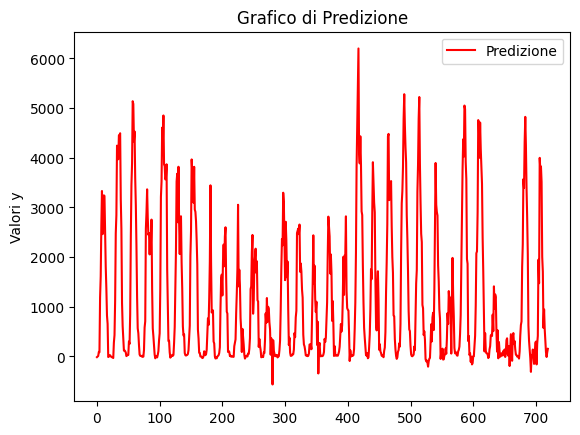

In [26]:
plt.plot(range(len(y_pred_A)), y_pred_A, label='Predizione', color='red', linestyle='-')

# Aggiungi una legenda
plt.legend()

# Aggiungi etichette agli assi
plt.ylabel('Valori y')

# Titolo del grafico
plt.title('Grafico di Predizione')

# Mostra il grafico
plt.show()

In [27]:
df = pd.DataFrame({'Prediction':y_pred_A})

In [28]:
threshold = 0.05
df['Prediction'] = df['Prediction'].apply(lambda x: 0 if x < threshold else x)

In [29]:
df.to_csv('A.csv')